# VLSI - CP Part
Di Tuccio Gianluca, Orsini Lorenzo

In [1]:
from minizinc import Instance, Model, Solver
import minizinc
from datetime import timedelta
import time
import pandas as pd
import os
from tqdm import tqdm
random_seed = 42

'''
SET HERE THE PATH OF THE MAIN FOLDER (i.e VLSI folder)
            |
            |
            V
'''
os.chdir('/Users/gianlucadituccio/Documents/VLSI')
from utils.utils import *

## CP Code

In [ ]:
async def solve_model(model_path, solver, parameters, timeout, rotation=False, simmetry=False, free_search=False):
    
    # load the model
    model = minizinc.Model(model_path)
    solver = minizinc.Solver.lookup(solver)
    instance = minizinc.Instance(solver, model)

    # sort rectangles by y components (if they are equal, then compare x components)
    rectangles = [(x, y, i) for i, (x, y) in enumerate(zip(parameters['x_components'], parameters['y_components']))]
    sorted_rectangles = sorted(rectangles, key=lambda x: (x[1],x[0]), reverse=True)
    x_components = [k[0] for k in sorted_rectangles]
    y_components = [k[1] for k in sorted_rectangles]
    original_indices = [k[2] for k in sorted_rectangles]
    
    # assign the parameters to the model
    instance['w'] = parameters['w']
    instance['n'] = parameters['n_rectangles']
    instance['x_components']=x_components
    instance['y_components']=y_components
    instance['min_h']=parameters['min_h']
    if x_components[0] > y_components[0] and rotation and simmetry:
        instance['first_rectangle_rot']=True
    elif rotation: instance['first_rectangle_rot']=False
    
    # create the output variable for storing the results
    output = {}
    
    # change the name of the variables if the model has the rotation enabled
    try:
        # solve the problem
        t1 = time.time()
        result = await instance.solve_async(timeout=timedelta(seconds=timeout), random_seed=random_seed, processes=8, free_search=free_search)
        t2 = time.time()
        
        if rotation:
            # restore the order before the sort by y components
            positions = [(x, y, i, z, k) for x, y, i, z, k in zip(result['x_positions'], 
                                                            result['y_positions'], 
                                                            result['x_components_rot'], 
                                                            result['y_components_rot'],
                                                            original_indices)]
        
        else:
            positions = [(x, y, i, z, k) for x, y, i, z, k in zip(result['x_positions'], 
                                                            result['y_positions'], 
                                                            x_components, 
                                                            y_components,
                                                            original_indices)]
        # store the results
        sorted_positions = sorted(positions, key=lambda x: x[4])
        output['x_positions'], output['y_positions'], output['x_components'], output['y_components'], _ = zip(*sorted_positions)
            
        # save h found, initial W and the computational time
        output['h'] = result['h']
        output['W'] = parameters['w']
        output['time'] = t2-t1
        output['h_min'] = parameters['min_h']
        return output
    
    except Exception as ex: 
        print(ex)
        return {}

Here, you can find the code for testing the model with the better configuration (as explained later). You can select the rotation model with ***rotation=True***.<br>
Besides, you can select the type of the solver (***Gecode*** or ***Chuffed***) and if to use ***simmetry*** or not, and ***free search***.

In [ ]:
rotation = True # True --> enable rotation
solver = 'chuffed' # 'gecode' or 'chuffed'
simmetry = True # True --> enable simmetry
free_search = True

for i in tqdm(range(1,41)):
    model_name = ''
    if simmetry: model_name = 'VLSI_simmetry.mzn' if not rotation else 'VLSI_simmetry_rotation.mzn'
    else: model_name = 'VLSI.mzn' if not rotation else 'VLSI_rotation.mzn'
    file = LoadInstance('utils/instances/',f'ins-{i}.txt')
    result = await solve_model(model_path='CP/src/'+model_name, solver=solver, 
                               parameters=file, timeout=300, rotation=rotation, 
                               simmetry=simmetry, free_search=free_search)
    if result:
        # if you want plot the results without saving them, use: PlotInstance(result)
        PlotInstance(result, 
                     path='CP/images', 
                     name='fig-'+str(i) if not rotation else 'rotation_fig-'+str(i))
        WriteInstance(result,
                     path='CP/out',
                     name='out-'+str(i) if not rotation else 'rotation_out-'+str(i))
    else:
        print('Instance', i, 'TIMEOUT')

## Gecode VS Chuffed with and without SB (No Rotation)

In [15]:
results = pd.read_csv('utils/datasets/CP_h.csv').replace(np.nan, 'N/A')
results = results.reset_index(drop=True)
results = results.set_index("Instance")
results.applymap(lambda x: int(x) if x !='N/A' else x).style.apply(highlight_h_min, axis=1)

,h_min,Gecode w/out SB,Gecode + SB,Chuffed w/out SB,Chuffed + SB
Instance,,,,,
1,8,8,8,8,8
2,9,9,9,9,9
3,10,10,10,10,10
4,11,11,11,11,11
5,12,12,12,12,12
6,13,13,13,13,13
7,14,14,14,14,14
8,15,15,15,15,15
9,16,16,16,16,16


In [16]:
results = pd.read_csv('utils/datasets/CP_time.csv')
Statistics({'Gecode w/out SB':results['Gecode w/out SB'],
            'Gecode + SB':results['Gecode + SB'],
            'Chuffed w/out SB':results['Chuffed w/out SB'],
            'Chuffed + SB':results['Chuffed + SB']})
results = results.replace('H', 0)
results = results.astype(float)
results = results.reset_index(drop=True)
results = results.set_index("Instance")
print()
print('GREEN --> BEST VALUE,\nYELLOW --> WORST VALUE,\nRED --> TIMEOUT')
results.style.apply(highlight_max, axis=1).apply(highlight_min, axis=1).apply(highlight_timeout, axis=1).set_properties(**{'border-top': '2px solid', 'border-bottom': '2px solid'}, axis=1)

TIMEOUT is seen as 300s.

Non Optimal solution has required 300s.

+---------------------------------+-----------------+-------------+------------------+--------------+
|                                 | Gecode w/out SB | Gecode + SB | Chuffed w/out SB | Chuffed + SB |
+---------------------------------+-----------------+-------------+------------------+--------------+
|          Total Time [s]         |        8103.115 |    7803.732 |           630.27 |      491.659 |
|             Max [s]             |           300.0 |       300.0 |            300.0 |        300.0 |
|             Min [s]             |           0.212 |        0.21 |            0.159 |        0.161 |
|             Mean [s]            |         202.578 |     195.093 |           15.757 |       12.291 |
|             Std [s]             |         142.189 |     144.785 |           50.753 |       48.287 |
| Instances Solved with H optimal |           13/40 |       14/40 |            39/40 |        39/40 |
+--------------

,Gecode w/out SB,Gecode + SB,Chuffed w/out SB,Chuffed + SB
Instance,,,,
1.0,0.212737,0.209565,0.158853,0.161359
2.0,0.218118,0.217303,0.165544,0.169902
3.0,0.213022,0.211484,0.174524,0.170856
4.0,0.213470,0.212261,0.163025,0.167597
5.0,0.214329,0.216354,0.164041,0.170944
6.0,0.215047,0.223083,0.164490,0.177056
7.0,0.212033,0.214275,0.164343,0.175173
8.0,0.228286,0.216326,0.166916,0.177851
9.0,0.215738,0.213115,0.165992,0.183496


## Gecode VS Chuffed with and without SB (With Rotation)

In [19]:
results = pd.read_csv('utils/datasets/CP_rotation_h.csv').replace(np.nan, 'N/A')
results = results.reset_index(drop=True)
results = results.set_index("Instance")
results.applymap(lambda x: int(x) if x !='N/A' else x).style.apply(highlight_h_min, axis=1)

,h_min,Gecode w/out SB,Gecode + SB,Chuffed w/out SB,Chuffed + SB
Instance,,,,,
1,8,8,8,8,8
2,9,9,9,9,9
3,10,10,10,10,10
4,11,11,11,11,11
5,12,12,12,12,12
6,13,13,13,13,13
7,14,14,14,14,14
8,15,15,15,15,15
9,16,16,16,16,16


In [10]:
results = pd.read_csv('utils/datasets/CP_rotation_time.csv')
Statistics({'Gecode w/out SB':results['Gecode w/out SB'],
            'Gecode + SB':results['Gecode + SB'],
            'Chuffed w/out SB':results['Chuffed w/out SB'],
            'Chuffed + SB':results['Chuffed + SB']})
results = results.replace('H', 0)
results = results.astype(float)
results = results.reset_index(drop=True)
results = results.set_index("Instance")
print()
print('GREEN --> BEST VALUE,\nYELLOW --> WORST VALUE,\nRED --> TIMEOUT')
results.style.apply(highlight_max, axis=1).apply(highlight_min, axis=1).apply(highlight_timeout, axis=1).set_properties(**{'border-top': '2px solid', 'border-bottom': '2px solid'}, axis=1)

TIMEOUT is seen as 300s.

Non Optimal solution has required 300s.

+---------------------------------+-----------------+-------------+------------------+--------------+
|                                 | Gecode w/out SB | Gecode + SB | Chuffed w/out SB | Chuffed + SB |
+---------------------------------+-----------------+-------------+------------------+--------------+
|          Total Time [s]         |        7804.947 |    7804.135 |         2001.613 |     1984.004 |
|             Max [s]             |           300.0 |       300.0 |            300.0 |        300.0 |
|             Min [s]             |           0.216 |       0.212 |            0.163 |        0.162 |
|             Mean [s]            |         195.124 |     195.103 |            50.04 |         49.6 |
|             Std [s]             |         144.743 |     144.771 |           94.943 |       97.914 |
| Instances Solved with H optimal |           14/40 |       14/40 |            37/40 |        36/40 |
+--------------

,Gecode w/out SB,Gecode + SB,Chuffed w/out SB,Chuffed + SB
Instance,,,,
1.0,0.216175,0.215081,0.162994,0.162390
2.0,0.221796,0.212432,0.168599,0.168664
3.0,0.221827,0.230507,0.172156,0.167628
4.0,0.268364,0.216198,0.173861,0.176315
5.0,0.266104,0.304123,0.167861,0.247306
6.0,0.234961,0.236478,0.318970,0.335286
7.0,0.318063,0.218607,0.427608,0.293460
8.0,0.269844,0.337062,0.179308,0.519640
9.0,0.404835,0.227031,0.178442,0.310590


## Best Models with and without Rotation

In [11]:
results = pd.DataFrame()
results['Chuffed w/out SB w/out R'] = pd.read_csv('utils/datasets/CP_time.csv')['Chuffed w/out SB']
results['Chuffed + SB w/out R'] = pd.read_csv('utils/datasets/CP_time.csv')['Chuffed + SB']
results['Chuffed w/out SB + R'] = pd.read_csv('utils/datasets/CP_rotation_time.csv')['Chuffed w/out SB']
results['Chuffed + SB + R'] = pd.read_csv('utils/datasets/CP_rotation_time.csv')['Chuffed + SB']
Statistics({'CH w/out SB w/out R':results['Chuffed w/out SB w/out R'],
            'CH + SB w/out R':results['Chuffed + SB w/out R'],
            'CH w/out SB + R':results['Chuffed w/out SB + R'],
            'CH + SB + R':results['Chuffed + SB + R']})

TIMEOUT is seen as 300s.

Non Optimal solution has required 300s.

+---------------------------------+---------------------+-----------------+-----------------+-------------+
|                                 | CH w/out SB w/out R | CH + SB w/out R | CH w/out SB + R | CH + SB + R |
+---------------------------------+---------------------+-----------------+-----------------+-------------+
|          Total Time [s]         |              630.27 |         491.659 |        2001.613 |    1984.004 |
|             Max [s]             |               300.0 |           300.0 |           300.0 |       300.0 |
|             Min [s]             |               0.159 |           0.161 |           0.163 |       0.162 |
|             Mean [s]            |              15.757 |          12.291 |           50.04 |        49.6 |
|             Std [s]             |              50.753 |          48.287 |          94.943 |      97.914 |
| Instances Solved with H optimal |               39/40 |           3

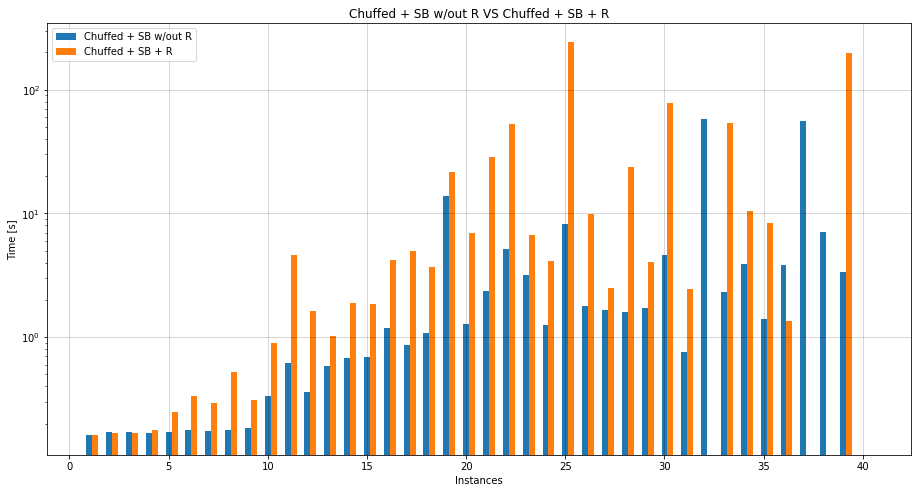

In [12]:
PlotStats({'Chuffed + SB w/out R':results['Chuffed + SB w/out R'].replace('H', 0), 
            'Chuffed + SB + R':results['Chuffed + SB + R'].replace('H', 0)},
            x_axis=list(pd.read_csv('utils/datasets/CP_time.csv')['Instance']))